# Viz - Lasso Casual

In [1]:
%matplotlib inline

from util_functions import *
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

set_env_path()
conn, cur = aws_connect()

query = """
SELECT 
EXTRACT(DOY FROM date) as day_of_year,
CASE WHEN day_of_week = any('{0,6}') THEN 1 ELSE 0 END as weekend_dummy,
date,
daylight_hours,
apparenttemperaturehigh,
cloudcover,
humidity,
precipaccumulation,
precipintensitymax,
precipprobability,
rain,
snow,
visibility,
windspeed,
us_holiday,
nats_single,
nats_double,
dc_bike_event,
dc_pop,
cabi_trips_wdc_to_wdc,
cabi_trips_wdc_to_wdc_casual,
dless_trips_all
from final_db"""

pd.options.display.max_rows = None
pd.options.display.max_columns = None

df = pd.read_sql(query, con=conn)

# Setting date to index for easier splitting
df.set_index(df.date, drop=True, inplace=True)
df.index = pd.to_datetime(df.index)

# Encode day_of_year as cyclical
df['sin_day_of_year'] = np.sin(2*np.pi*df.day_of_year/365)
df['cos_day_of_year'] = np.cos(2*np.pi*df.day_of_year/365)

train = df.loc['2013-01-01':'2017-09-08']
test = df.loc['2017-09-09':'2018-04-30']

# Specify columns to keep and drop for X and y
drop_cols = ['date', 'dless_trips_all']
y_cols = ['cabi_trips_wdc_to_wdc', 'cabi_trips_wdc_to_wdc_casual']

feature_cols = [col for col in df.columns if (col not in y_cols) & (col not in drop_cols)]

# X y split
Xtrain_raw = train[feature_cols]

# Our target variable here is casual DC to DC trips
ytrain = train[y_cols[1]]
Xtest_raw = test[feature_cols]
ytest = test[y_cols[1]]
print(Xtrain_raw.shape, ytrain.shape, Xtest_raw.shape, ytest.shape)

# Pull out dockless trips
dless = test['dless_trips_all']

(1712, 20) (1712,) (234, 20) (234,)


In [2]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin

class Columns(BaseEstimator, TransformerMixin):
    """ 
    This is a custom transformer for splitting the data into subsets for FeatureUnion.
    """
    def __init__(self, names=None):
        self.names = names

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X):
        return X[self.names]

pf = PolynomialFeatures(2, include_bias=False)

Xtrain_pf_array = pf.fit_transform(Xtrain_raw)
Xtest_pf_array = pf.transform(Xtest_raw)

# Get feature names 
Xtrain_cols = pf.get_feature_names(Xtrain_raw.columns)

# Convert arrays to dfs with the new pf column names
Xtrain_pf = pd.DataFrame(Xtrain_pf_array, columns=Xtrain_cols)
Xtest_pf = pd.DataFrame(Xtest_pf_array, columns=Xtrain_cols)

to_drop = [
    'rain^2', 'snow^2', 'us_holiday^2', 'nats_single^2', 'nats_double^2', 
    'dc_bike_event^2', 'sin_day_of_year^2', 'cos_day_of_year^2',
    'sin_day_of_year cos_day_of_year', 'weekend_dummy^2'
]

Xtrain_pf2 = Xtrain_pf.drop(labels=to_drop, axis=1)
Xtest_pf2 = Xtest_pf.drop(labels=to_drop, axis=1)

binary = [col for col in Xtrain_pf2.columns if Xtrain_pf2[col].nunique() == 2]
cont = [col for col in Xtrain_pf2.columns if col not in binary]

cols = binary + cont

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('binary', Pipeline([
            ('bincols', Columns(names=binary)),
            ('minmax', MinMaxScaler())
        ])),
        ('continuous', Pipeline([
            ('contcols', Columns(names=cont)),
            ('scaler', StandardScaler())
        ]))
    ]))   
])

# Fit and transform to create our final Xtrain and Xtest

pipeline.fit(Xtrain_pf2)
Xtrain_scaled = pipeline.transform(Xtrain_pf2)
Xtest_scaled = pipeline.transform(Xtest_pf2)

# Put everything back into dfs
Xtrain = pd.DataFrame(Xtrain_scaled, columns=cols)
Xtest = pd.DataFrame(Xtest_scaled, columns=cols)
print(Xtrain.shape, Xtest.shape)

(1712, 220) (234, 220)


In [3]:
from sklearn.externals import joblib

lasso = joblib.load('lasso_casual.pkl') 

...........................................................................................................................................................................................................................C:\Users\Sebastian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

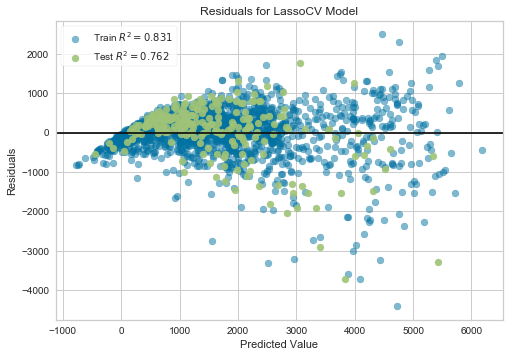

In [4]:
from yellowbrick.regressor import ResidualsPlot

resplot = ResidualsPlot(lasso)

resplot.fit(Xtrain, ytrain)
resplot.score(Xtest, ytest)
g = resplot.poof()

.......................................................................................................................................................................................................................C:\Users\Sebastian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

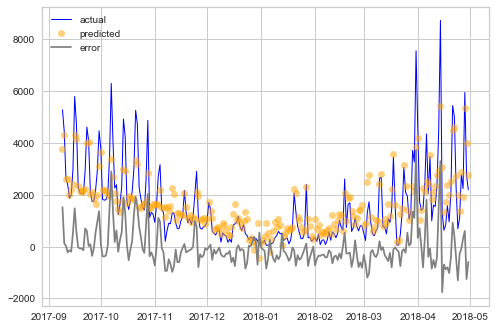

In [5]:
lasso.fit(Xtrain, ytrain)

yhat = lasso.predict(Xtest)
error = ytest - yhat

data = pd.DataFrame({'t': test['date'], 
                     'ytest': ytest, 
                     'yhat': yhat,
                     'error': error,
                     'neg_error': np.negative(error),
                     'dless': dless})

plt.plot('t', 'ytest', data=data, color='blue', linewidth=1, label='actual')
plt.plot('t', 'yhat', data=data, color='orange', marker='o', linestyle="None", label='predicted', alpha=0.5)
plt.plot('t', 'error', data=data, color='gray')
plt.legend()
plt.show()

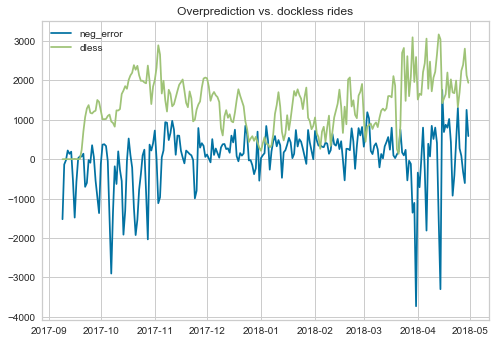

In [6]:
# Negative error is the amount our model overpredicted by (predicted - actual)
plt.plot('t', 'neg_error', data=data)
plt.plot('t', 'dless', data=data)
plt.title('Overprediction vs. dockless rides')
plt.legend()

In [7]:
print(data.head(10))

# Atypical dockless data before 9/20 so we can cut off there for graphing purposes
data = data.loc['2017-09-20':]

data.head()

            dless        error    neg_error           t         yhat   ytest
date                                                                        
2017-09-09    0.0  1522.151458 -1522.151458  2017-09-09  3761.848542  5284.0
2017-09-10    2.0   132.626802  -132.626802  2017-09-10  4318.373198  4451.0
2017-09-11    3.0    24.227250   -24.227250  2017-09-11  2594.772750  2619.0
2017-09-12    2.0  -221.642421   221.642421  2017-09-12  2619.642421  2398.0
2017-09-13    0.0  -135.839347   135.839347  2017-09-13  2005.839347  1870.0
2017-09-14    3.0  -191.320895   191.320895  2017-09-14  2183.320895  1992.0
2017-09-15    3.0   531.248881  -531.248881  2017-09-15  2434.751119  2966.0
2017-09-16    8.0  1480.124582 -1480.124582  2017-09-16  4314.875418  5795.0
2017-09-17    3.0   570.168154  -570.168154  2017-09-17  4164.831846  4735.0
2017-09-18    3.0   -23.769165    23.769165  2017-09-18  2328.769165  2305.0


,dless,error,neg_error,t,yhat,ytest
date,,,,,,
2017-09-20,237.0,-67.689572,67.689572,2017-09-20,2124.689572,2057.0
2017-09-21,706.0,-140.377867,140.377867,2017-09-21,2168.377867,2028.0
2017-09-22,1068.0,700.741993,-700.741993,2017-09-22,2226.258007,2927.0
2017-09-23,1287.0,601.052478,-601.052478,2017-09-23,4012.947522,4614.0
2017-09-24,1373.0,21.970986,-21.970986,2017-09-24,4058.029014,4080.0


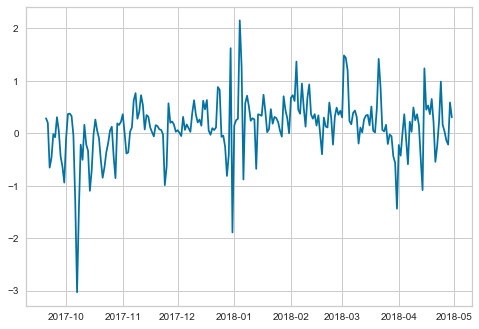

In [8]:
data['dless_impact'] = data['neg_error']/data['dless']
plt.plot('t', 'dless_impact', data=data)

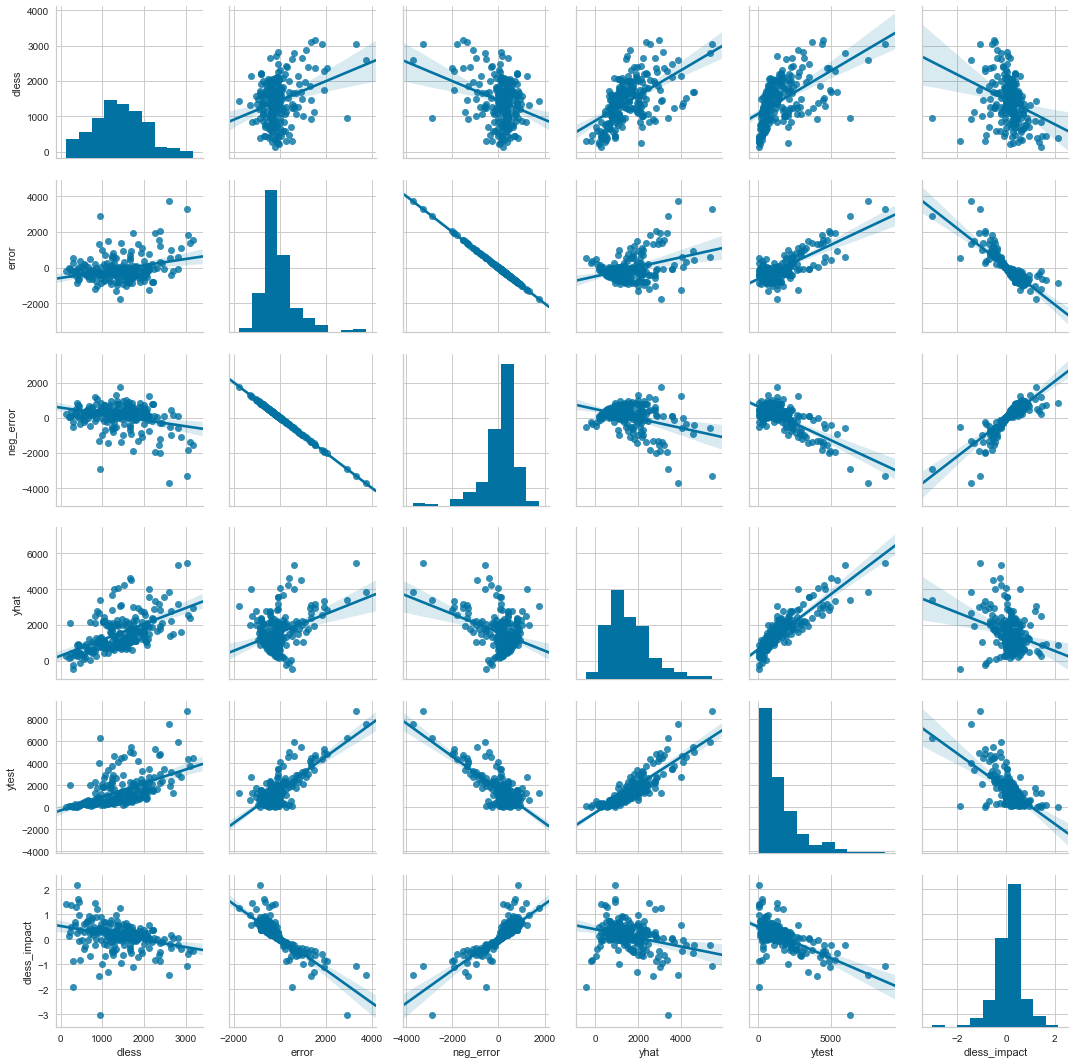

In [9]:
sns.pairplot(data, kind='reg')

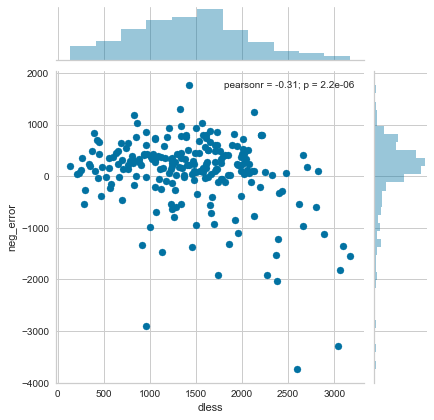

In [10]:
sns.jointplot('dless', 'neg_error', data=data)